In [26]:
!nvidia-smi

Sun Aug 20 05:48:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   5051MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install diffusers==0.11.1 -qq
!pip install transformers scipy ftfy accelerate -qq

In [7]:
from PIL import Image
import numpy as np
import torch
from diffusers import AutoencoderKL

device = 'cuda'

vae = AutoencoderKL.from_pretrained(
    'runwayml/stable-diffusion-v1-5', subfolder='vae')
vae = vae.to(device)

def encode_img_latents(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    img_arr = np.stack([np.array(img) for img in imgs], axis=0)
    img_arr = img_arr / 255.0
    img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
    img_arr = 2 * (img_arr - 0.5)

    latent_dists = vae.encode(img_arr.to(device))
    latent_samples = latent_dists.latent_dist.sample()
    latent_samples *= 0.18215

    return latent_samples

def decode_img_latents(latents):
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        imgs = vae.decode(latents)

    imgs = (imgs.sample / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in imgs]
    return pil_images


def concat_image(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def concat_image(im_list):

    img_number = len(im_list)

    if img_number == 0:
        return None

    dst = Image.new('RGB', (img_number * im_list[0].width, im_list[0].height))
    for idx, im in enumerate(im_list, 0):
        dst.paste(im, (idx * im.width, 0))

    return dst

In [22]:
from io import BytesIO
import requests

pths = ["https://i.mji.rip/2023/07/30/8cdd247e17daa5cf2ba1098b97bfc730.png", "https://i.mji.rip/2023/07/30/16b3f4d60406eeca38b8f9000b465673.png"]

all_img_latents = []
for pth in pths:  # 重构图像，可以点开文件夹查看重构结构
    response = requests.get(pth)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize((256, 256))

    img_latents = encode_img_latents(img)
    all_img_latents.append(img_latents)
    dec_img = decode_img_latents(img_latents)[0]
    concat_image([img, dec_img]).save(pth.split("/")[-1])

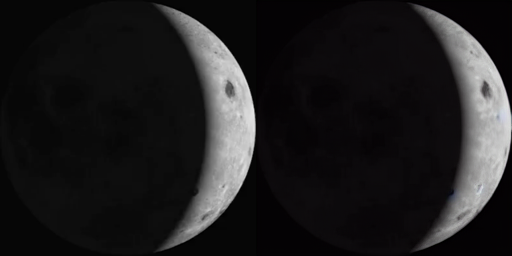

In [23]:
# 检查VAE重建效果
img = Image.open("/content/16b3f4d60406eeca38b8f9000b465673.png")
img

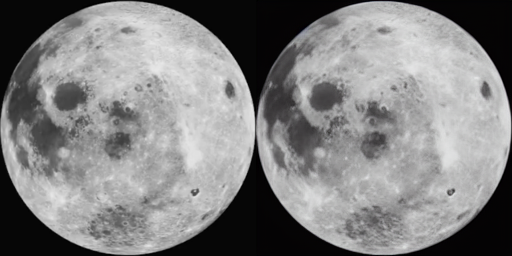

In [24]:
# 检查VAE重建效果
img = Image.open("/content/8cdd247e17daa5cf2ba1098b97bfc730.png")
img

## 使用VAE进行插值

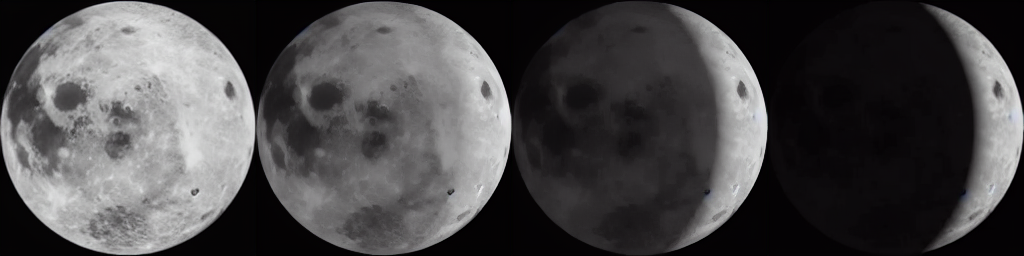

In [25]:
num_steps = 4 # 插值得到中间的4张图，可以点开文件夹查看插值结果
interpolation_weight = np.linspace(0, 1, num_steps)
result_imgs = []
for weight in interpolation_weight:
    interval_latents = (1 - weight) * all_img_latents[0] + weight * all_img_latents[1]
    dec_img = decode_img_latents(interval_latents)[0]
    result_imgs.append(dec_img)
concat_image(result_imgs)